In [1]:
import numpy as np
import time, os, sys
from glob import glob
from tifffile import imread
from skimage import io
from tqdm import tqdm
import pandas as pd
import pickle
from albumentations import *
import cv2

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import tensorflow as tf
tf.enable_eager_execution()

from lib import dataloader

%config IPCompleter.greedy=True

print(tf.__version__)

1.12.3


In [2]:
def plot_nd(arr, cmap='gray', figsize=(15,15)):
    nd = len(arr)
    fig, axes = plt.subplots(ncols=nd, figsize=figsize)
    for img, ax in zip(arr, axes.flatten()):
        ax.imshow(img, cmap=cmap)
    plt.show()

In [3]:
HOME = '/home/lis-paul'
# HOME = '/home/qzt'
PATH = "data/dsb2018/dsb2018_sub1/"
# PATH = "data/centuri/train/"
# path = os.path.join(HOME, "data/dsb2018/dsb2018_sub1/images/*.tif")
pathX = os.path.join(HOME, PATH+"images/*.tif")
pathY = os.path.join(HOME, PATH+"masks/*.tif")
X_file = sorted(glob(pathX))
Y_file = sorted(glob(pathY))
print(len(X_file), len(Y_file))

X = list(map(io.imread,X_file))
Y = list(map(io.imread,Y_file))
# n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

292 292


In [4]:
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]

## manual assign train/val index for debugging
# ind_train = [1,2,3,4]
# ind_val = [0]

X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 292
- training:       248
- validation:      44


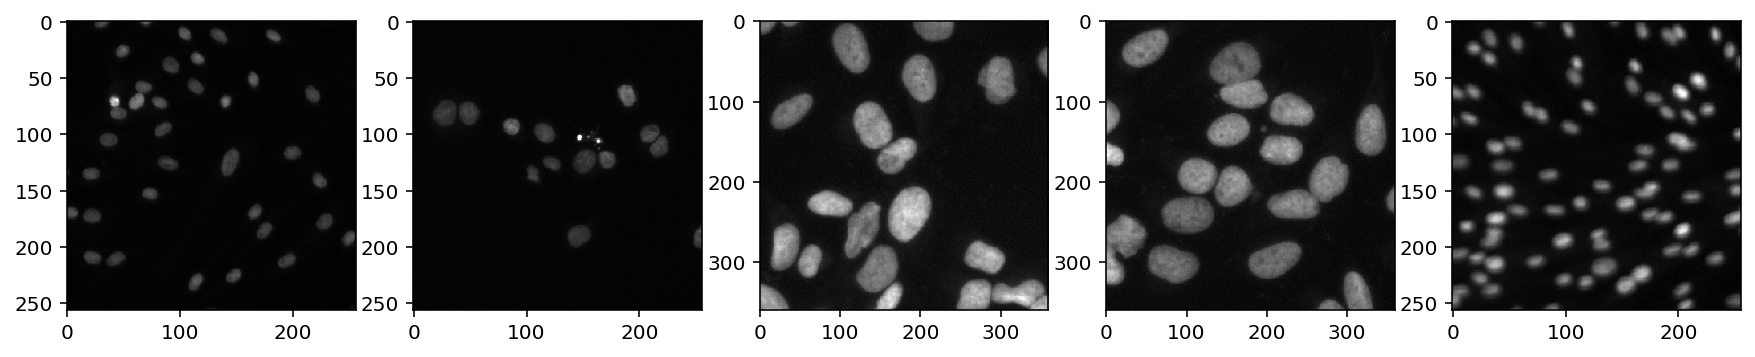

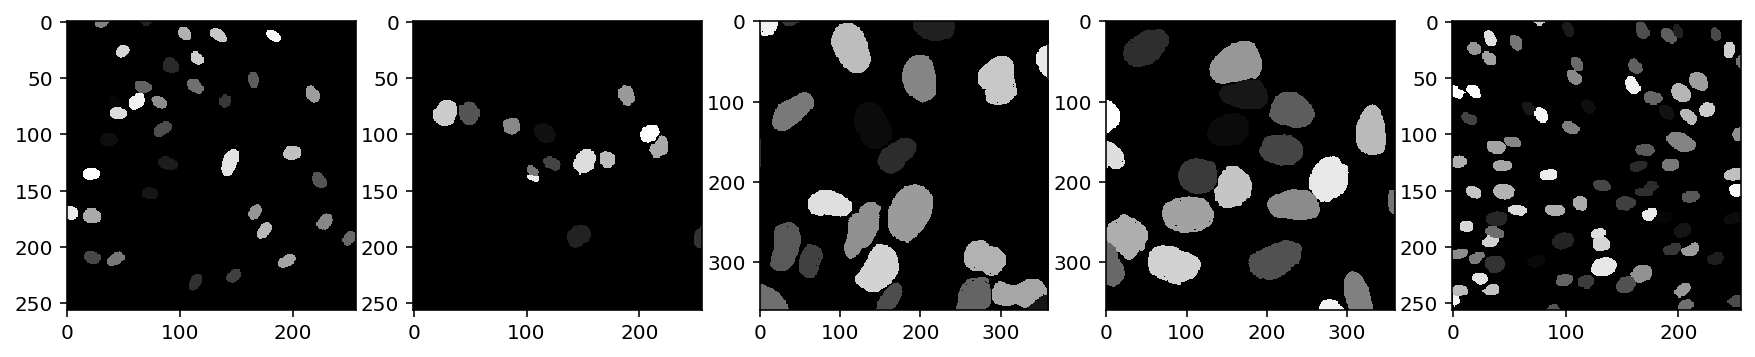

In [5]:
plot_nd(X[:5])
plot_nd(Y[:5])

In [6]:
ranf=list(np.random.ranf(8)+10*np.random.ranf(1))
AUG = Compose([
        CoarseDropout(max_holes=64, max_height=8, max_width=8, min_holes=None, min_height=None, min_width=None, 
                  fill_value=ranf, always_apply=False, p=.9),
        GaussNoise(var_limit=(0.0, 0.05), mean=0, p=.5),
        GaussianBlur(blur_limit=3, p=.5),
        Flip(p=0.5),
        ShiftScaleRotate(shift_limit=0, scale_limit=(0.2, 1), rotate_limit=15, 
                         interpolation=0, border_mode=cv2.BORDER_REFLECT_101, value=0, mask_value=0, p=.9),
        ElasticTransform(alpha=100, sigma=10, alpha_affine=1, p=0.7, 
                         interpolation=0, border_mode=cv2.BORDER_REFLECT_101, value=0, mask_value=0),
        RandomCrop(256, 256, always_apply=True, p=1.0)
    ], p=0.9)

AUG_val = RandomCrop(256, 256, always_apply=True, p=1.0)

In [15]:
train_dl = dataloader.Dataloader(X_trn, Y_trn, batch_size=8, patch_size=(256,256), augmenter=AUG, shuffle=True)
val_dl   = dataloader.Dataloader(X_val, Y_val, batch_size=4, patch_size=(256,256), augmenter=AUG_val, shuffle=False)

In [16]:
xx, yy = train_dl[0]

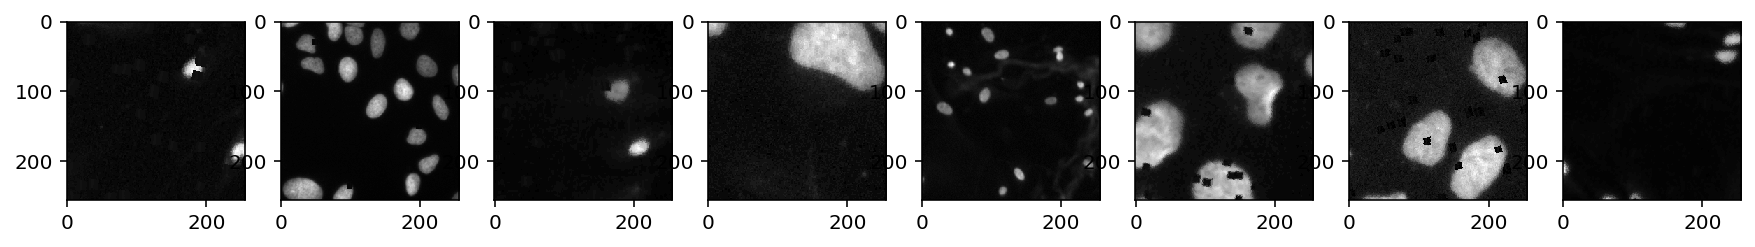

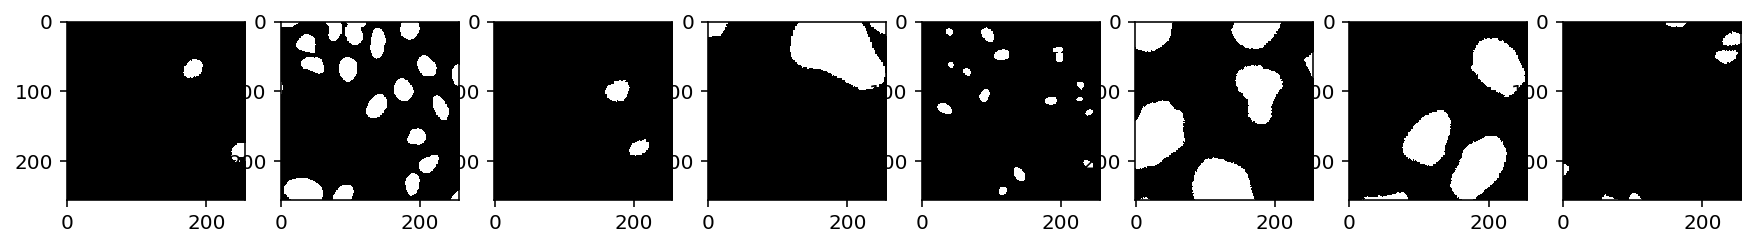

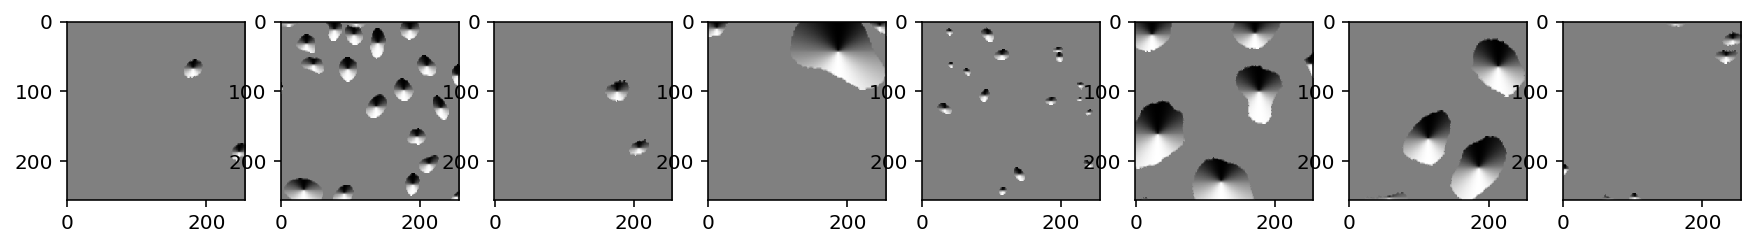

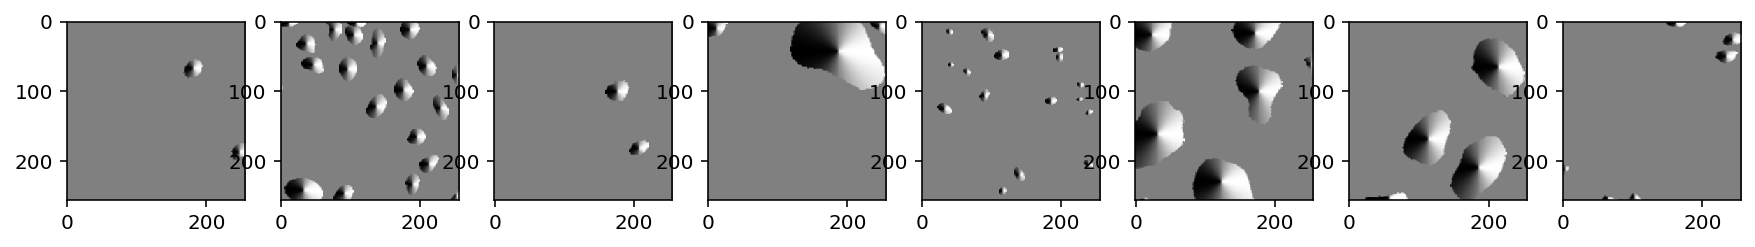

In [17]:
for arr in [xx, yy[0], yy[1], yy[2]]:
    plot_nd(arr)
